In [1]:
!pip install scikit-surprise

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import NormalPredictor

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
places = pd.read_excel('data/tourism_with_id.xlsx')
ratings = pd.read_csv('data/tourism_rating.csv')
users = pd.read_csv('data/user.csv')

##### Inspect tourism_with_id.xlsx

In [4]:
places.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [5]:
places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [6]:
# Drop columns we don't care about.
# 'Description', 'Time_minutes, Coordinate, Lat, Long, Unamed: 11 and 12

places.drop(['Description', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11', 'Unnamed: 12'], axis=1, inplace=True)

places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Place_Id    437 non-null    int64  
 1   Place_Name  437 non-null    object 
 2   Category    437 non-null    object 
 3   City        437 non-null    object 
 4   Price       437 non-null    int64  
 5   Rating      437 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 20.6+ KB


In [7]:
# find duplicate rows across all columns
places[places.duplicated()]

,Place_Id,Place_Name,Category,City,Price,Rating


In [8]:
# find missing values across all columns
places.isna().sum()

Place_Id      0
Place_Name    0
Category      0
City          0
Price         0
Rating        0
dtype: int64

##### Inspect user.csv

In [9]:
users.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


In [11]:
#find duplicate rows across all columns
users[users.duplicated()]

,User_Id,Location,Age


In [12]:
# find missing values across all columns
users.isna().sum()

User_Id     0
Location    0
Age         0
dtype: int64

##### Inspect ourism_rating.csv'

In [13]:
ratings.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [14]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [15]:
#find duplicate rows across all columns
ratings[ratings.duplicated()]

,User_Id,Place_Id,Place_Ratings
29,1,328,2
129,5,321,3
144,5,301,2
166,6,64,5
187,7,213,3
...,...,...,...
9626,289,413,1
9682,291,91,3
9690,291,431,4
9814,295,403,1


In [16]:
# Found duplicates in ratings. Keep the first and drop the rest
ratings.drop_duplicates(inplace = True)
ratings.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [17]:
#find duplicate rows across all columns
ratings[ratings.duplicated()]

,User_Id,Place_Id,Place_Ratings


In [18]:
# find missing values across all columns
ratings.isna().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64

In [19]:
print(f"Ratings range from {ratings['Place_Ratings'].min()} to {ratings['Place_Ratings'].max()}")

Ratings range from 1 to 5


# Explore the user group that provides the tourism ratings by:
* Analyzing the age distribution of users visiting the places and rating them

<Axes: xlabel='Age', ylabel='Location'>

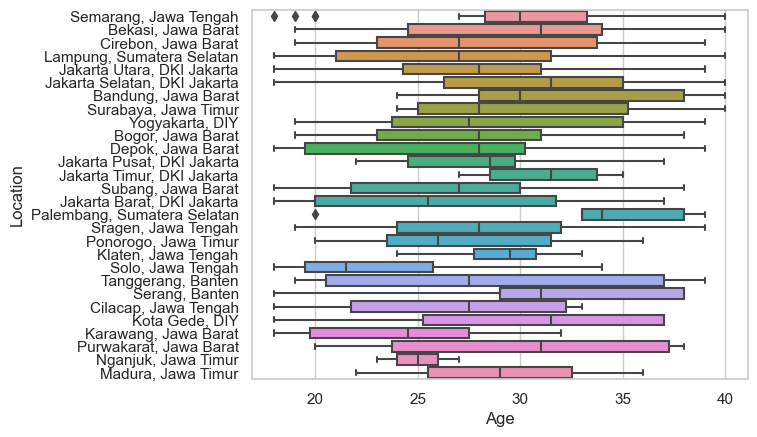

In [20]:
sns.set(style='whitegrid')
 
sns.boxplot(x="Age",
                y="Location",
                data=users)

There are some sites that are more popular among younger generations, some that are more popular among older generations, and some that are popular among all age groups.



> 2. What kind of tourism each city/location most famous or suitable for ?


In [21]:
crosstab = pd.crosstab(index=places["Category"], columns=places["City"])
crosstab

City,Bandung,Jakarta,Semarang,Surabaya,Yogyakarta
Category,,,,,
Bahari,0,8,4,1,34
Budaya,22,32,15,18,30
Cagar Alam,54,4,20,5,23
Pusat Perbelanjaan,1,10,0,1,3
Taman Hiburan,39,27,15,18,36
Tempat Ibadah,8,3,3,3,0


<Axes: xlabel='Category'>

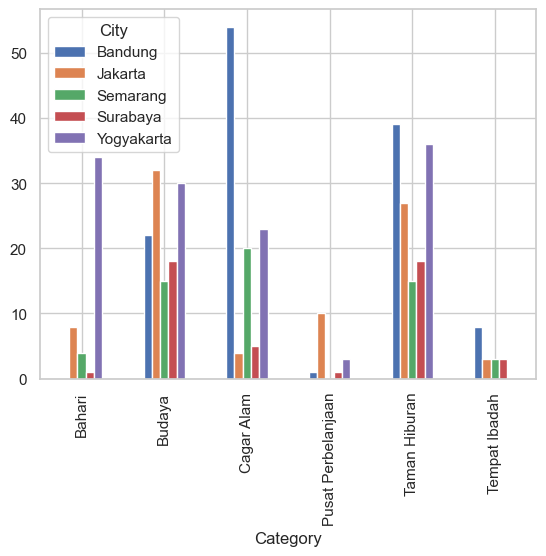

In [22]:
crosstab.plot(kind='bar')

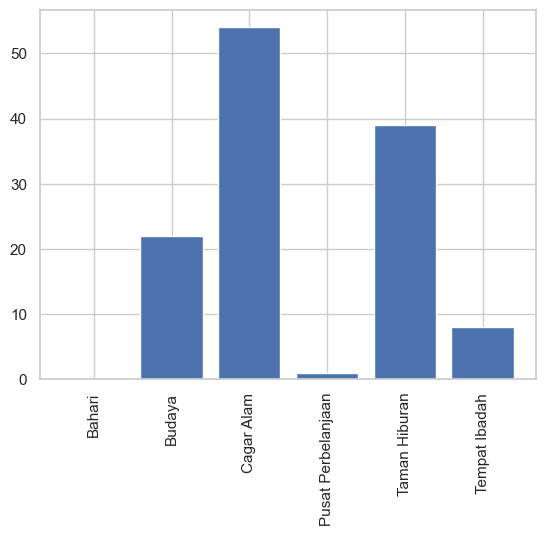

In [23]:
plt.bar(crosstab.index,crosstab.Bandung)
plt.xticks(rotation=90)
plt.show()

## Calculate weighted average ratings for each place

In [24]:
ratings.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [25]:
# Compute average ratings
avg_ratings = ratings[["Place_Id",'Place_Ratings']].groupby('Place_Id').mean()
avg_ratings.head()

,Place_Ratings
Place_Id,
1,3.722222
2,2.840000
3,2.526316
4,2.857143
5,3.520000


In [26]:
places.head()

,Place_Id,Place_Name,Category,City,Price,Rating
0,1,Monumen Nasional,Budaya,Jakarta,20000,4.6
1,2,Kota Tua,Budaya,Jakarta,0,4.6
2,3,Dunia Fantasi,Taman Hiburan,Jakarta,270000,4.6
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan,Jakarta,10000,4.5
4,5,Atlantis Water Adventure,Taman Hiburan,Jakarta,94000,4.5


In [27]:
place_ratings = pd.merge(places,avg_ratings, on = 'Place_Id')
place_ratings.head()

,Place_Id,Place_Name,Category,City,Price,Rating,Place_Ratings
0,1,Monumen Nasional,Budaya,Jakarta,20000,4.6,3.722222
1,2,Kota Tua,Budaya,Jakarta,0,4.6,2.840000
2,3,Dunia Fantasi,Taman Hiburan,Jakarta,270000,4.6,2.526316
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan,Jakarta,10000,4.5,2.857143
4,5,Atlantis Water Adventure,Taman Hiburan,Jakarta,94000,4.5,3.520000


# Build a Recommendation model for the tourists.


In [28]:
merged_data = pd.merge(places,ratings, on = 'Place_Id')
merged_data.head()

,Place_Id,Place_Name,Category,City,Price,Rating,User_Id,Place_Ratings
0,1,Monumen Nasional,Budaya,Jakarta,20000,4.6,36,4
1,1,Monumen Nasional,Budaya,Jakarta,20000,4.6,38,2
2,1,Monumen Nasional,Budaya,Jakarta,20000,4.6,64,2
3,1,Monumen Nasional,Budaya,Jakarta,20000,4.6,74,2
4,1,Monumen Nasional,Budaya,Jakarta,20000,4.6,86,4


In [29]:
merged_data[['User_Id', 'Place_Name','Place_Ratings']].head()

,User_Id,Place_Name,Place_Ratings
0,36,Monumen Nasional,4
1,38,Monumen Nasional,2
2,64,Monumen Nasional,2
3,74,Monumen Nasional,2
4,86,Monumen Nasional,4


In [30]:
utility_matrix = merged_data.groupby(['User_Id', 'Place_Name'])['Place_Ratings'].mean().unstack()
utility_matrix.head()

Place_Name,Air Mancur Menari,Air Terjun Kali Pancur,Air Terjun Kedung Pedut,Air Terjun Semirang,Air Terjun Sri Gethuk,Alive Museum Ancol,Alun Alun Selatan Yogyakarta,Alun-Alun Kota Bandung,Alun-alun Utara Keraton Yogyakarta,Amazing Art World,...,Wisata Alam Wana Wisata Penggaron,Wisata Batu Kuda,Wisata Eling Bening,Wisata Kaliurang,Wisata Kampung Krisan Clapar,Wisata Kraton Jogja,Wisata Kuliner Pecenongan,Wisata Lereng Kelir,Wisata Mangrove Tapak,Wot Batu
User_Id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,3.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(ratings[['User_Id', 'Place_Id', 'Place_Ratings']], reader=reader)
trainSet = data.build_full_trainset()

data

##### Evaluate and compare algos

In [32]:
#similarity options
sim_options = {'name':'msd'} # Mean Squared Distance

# Evaluate KNNBasic

algo = KNNBasic(k=20, sim_options=sim_options)
cross_validate(algo=algo, data=data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4637  1.4958  1.4620  1.4631  1.4608  1.4691  0.0134  
MAE (testset)     1.2509  1.2774  1.2399  1.2393  1.2532  1.2521  0.0138  
Fit time          0.00    0.01    0.00    0.00    0.00    0.00    0.00    
Test time         0.04    0.04    0.03    0.04    0.03    0.04    0.00    


{'test_rmse': array([1.46367199, 1.49579204, 1.46204073, 1.4631027 , 1.46084554]),
 'test_mae': array([1.25089806, 1.27742938, 1.23990063, 1.23925987, 1.25318739]),
 'fit_time': (0.0035598278045654297,
  0.005263090133666992,
  0.0037229061126708984,
  0.0032210350036621094,
  0.0033762454986572266),
 'test_time': (0.03874802589416504,
  0.04075312614440918,
  0.0334320068359375,
  0.03615307807922363,
  0.034715890884399414)}

In [33]:
#Evaluate Normal Predictor

algo = NormalPredictor()

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8661  1.8325  1.8394  1.8903  1.8370  1.8531  0.0220  
MAE (testset)     1.5245  1.4953  1.5000  1.5383  1.4930  1.5102  0.0180  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.00    0.01    0.00    


{'test_rmse': array([1.8660796 , 1.83251521, 1.83943859, 1.89030278, 1.83701273]),
 'test_mae': array([1.52449915, 1.49531585, 1.50002009, 1.53828086, 1.49296917]),
 'fit_time': (0.005100727081298828,
  0.006284952163696289,
  0.0054781436920166016,
  0.0054149627685546875,
  0.0053119659423828125),
 'test_time': (0.005402088165283203,
  0.005326032638549805,
  0.0052607059478759766,
  0.0051059722900390625,
  0.004995107650756836)}

In [34]:
# Evaluate Single Value Decomposition

algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4328  1.4212  1.4349  1.4127  1.4126  1.4229  0.0095  
MAE (testset)     1.2363  1.2213  1.2386  1.2083  1.2089  1.2227  0.0129  
Fit time          0.05    0.04    0.04    0.04    0.05    0.04    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.43283029, 1.42123302, 1.43486209, 1.41274766, 1.41263578]),
 'test_mae': array([1.23626542, 1.2213322 , 1.23862617, 1.20830112, 1.20890709]),
 'fit_time': (0.04990792274475098,
  0.04261517524719238,
  0.042986154556274414,
  0.04324793815612793,
  0.045124053955078125),
 'test_time': (0.007974863052368164,
  0.007503986358642578,
  0.010228872299194336,
  0.00738215446472168,
  0.007792949676513672)}

In [35]:
# Evaluate Non-negative Matrix Factorization

algo = NMF()
cross_validate(algo=algo, data=data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6722  1.6399  1.6533  1.6253  1.6224  1.6426  0.0185  
MAE (testset)     1.4037  1.3534  1.3865  1.3482  1.3503  1.3684  0.0225  
Fit time          0.09    0.09    0.09    0.09    0.10    0.09    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.67222486, 1.63990007, 1.65329975, 1.62530162, 1.62235064]),
 'test_mae': array([1.40369622, 1.35342165, 1.38652758, 1.34821954, 1.35030636]),
 'fit_time': (0.08961272239685059,
  0.08853912353515625,
  0.09103107452392578,
  0.09496307373046875,
  0.09949517250061035),
 'test_time': (0.006081104278564453,
  0.007304191589355469,
  0.007750272750854492,
  0.007921934127807617,
  0.007636070251464844)}

We are going with SVD

In [36]:
algo = SVD()

In [37]:
from surprise.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.25)

predictions = algo.fit(train).test(test)

predictions[0]

Prediction(uid=61, iid=26, r_ui=2.0, est=3.268925253451112, details={'was_impossible': False})

In [38]:
predictions

[Prediction(uid=61, iid=26, r_ui=2.0, est=3.268925253451112, details={'was_impossible': False}),
 Prediction(uid=277, iid=237, r_ui=4.0, est=3.146451688729528, details={'was_impossible': False}),
 Prediction(uid=111, iid=176, r_ui=5.0, est=3.312131640728689, details={'was_impossible': False}),
 Prediction(uid=170, iid=368, r_ui=2.0, est=2.603500484570186, details={'was_impossible': False}),
 Prediction(uid=257, iid=386, r_ui=2.0, est=2.8253207470639983, details={'was_impossible': False}),
 Prediction(uid=81, iid=378, r_ui=5.0, est=2.2876411419538654, details={'was_impossible': False}),
 Prediction(uid=184, iid=103, r_ui=4.0, est=3.10377760844808, details={'was_impossible': False}),
 Prediction(uid=264, iid=63, r_ui=3.0, est=3.395848808792021, details={'was_impossible': False}),
 Prediction(uid=188, iid=78, r_ui=2.0, est=2.446786825887994, details={'was_impossible': False}),
 Prediction(uid=235, iid=314, r_ui=5.0, est=3.1049507859937853, details={'was_impossible': False}),
 Prediction(u

In [39]:
pred = pd.DataFrame(predictions)

sample_user = pred['uid'][0]

reco = pred.loc[pred['uid'] == sample_user]
reco.sort_values(by=['est'],inplace=True,ascending = False)

place_list = reco.head(10)['iid'].to_list()

print(f"Recommendations for: {users.loc[users['User_Id'] == sample_user]}")
print()
places.loc[place_list]

Recommendations for:     User_Id             Location  Age
60       61  Nganjuk, Jawa Timur   23



,Place_Id,Place_Name,Category,City,Price,Rating
399,400,Hutan Bambu Keputih,Cagar Alam,Surabaya,0,4.3
142,143,Seribu Batu Songgo Langit,Cagar Alam,Yogyakarta,2000,4.6
301,302,Masjid Pusdai,Tempat Ibadah,Bandung,0,4.7
255,256,Wisata Batu Kuda,Cagar Alam,Bandung,10000,4.4
26,27,Sea World,Taman Hiburan,Jakarta,115000,4.5
410,411,Masjid Muhammad Cheng Hoo,Tempat Ibadah,Surabaya,0,4.7
366,367,Wisata Lereng Kelir,Cagar Alam,Semarang,7000,4.3
144,145,Desa Wisata Rumah Domes/Teletubbies,Taman Hiburan,Yogyakarta,5000,4.1
25,26,Pecinan Glodok,Pusat Perbelanjaan,Jakarta,0,4.3
9,10,Pulau Tidung,Bahari,Jakarta,150000,4.5
